# notebook with tasks for Capital One Data Science Challenge

## Executive Summary  

#### Question 1: Load

- a) Please describe the structure of the data. Number of records and fields in each record?
    - the number of records in total is 786,363 that span across 29 columns
    - there are numeric, text and date columns throughout the dataset but the date columns were not converted to dates upon initial import but were subsequently converted
    - there is a transactionDateTime column that is still stored as text after initial import that I converted to datetime format, along with currentExpDate, accountOpenDate and dateOfLastAddressChange
    - null values aren't counted as nulls but are rather empty strings upon initial import so i replaced these nulls with the value "blank"
    
- b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.
    - the numeric values have reasonable upper and lower limits: availableMoney has a negative value which is reasonable because the currentBalance is greater than the creditLimit by the amount of availableMoney
    - the non-date string values dont have many unique values other than merchantName, 2,490, and merchantCategoryCode, 19, which aren't problematic but would need to be consolidated if we want to use them in a logistic regression model to prevent separability
    - tables available inline later

#### Question 2: Plot
- b) Report any structure you find and any hypotheses you have about that structure. 
    - the histogram of the transaction amount is largely right-skewed with a long right tail, largely following a lognormal distribution
    - most of the density is for transaction amounts less than 500, which leads me to hypothesize that most of these transactions are for everyday consumer products, entertainment, travel and billpay transactions as opposed to larger transactions like rent and loan payments
    - another thing to note is that, because we'll be using this data to build a fraud model and most transactions seem like everyday purchases in that they're under \\$500, maybe the transactions over a certain dollar value, e.g. \\$1000, are more likely to be fraudulent
    
#### Question 3: Data Wrangling

- a) Can you programmatically identify reversed and multi-swipe transactions?
    - sort the transactions by accountNumber, customerId, cardLast4Digits and transactionDt
    - create copies of these variables and transactionAmount, transactionType and merchantName that are shifted so that the copied columns are shifted 1 row forward
    - identify reversed and multi_swipe transactions if the accountNumber, customerId, cardLast4Digits, transactionAmount and merchantName columns match for current and shift columns
        - within 24 hours
        - reversed if current row is reversal and shifted (previous) row is purchase and amounts match
        - multi-swipe if amount is the same and transactionType is purchase for current and shifted rows
        
- b) What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
    - 5,502 reversed transactions and 7,342 multi-swipe transactions out of all 786,363 transactions
    - \\$824K in reversed transactions and \\$1.08M for multi swipe transactions
    
- c) Did you find anything interesting about either kind of transaction?
    - I did not find any relationship between type of transaction and elevated percentages of reversed, multi-swipe or both kinds of duplicate transactions.
    - However, I did find that 6 merchant categories had no duplicate transactions at all - gym, fuel, cable/phone, online_subscriptions, food_delivery and mobileapps. I would hypothesize that this is something to do with card information saved so that it is not entered by a human and instead automated, i.e. recurring subscription transactions like gym, cable/phone, online_subscriptions are likely saved and entered in an automated fashion. Mobileapps and food_delivery could be transacted by a user using his or her card saved to their phone, minimizing the likelihood of a duplicate. Why fuel has no duplicate transactions is the most interesting because I would suspect plenty of customers would still insert their cards manually at the pump unless a significant portion of these transactions in this sample are customers using the cards on their phones. 
    
#### Question 4: Model

- a) Provide an estimate of performance using an appropriate sample, and show your work.
    - after creating an 85% training and 15% test set that are mutually exclusive and collectively exhaustive, my best model was a gradient-boosted tree model with the following performance
    - True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate, Precision and AUC are seen at the end of the notebook
    
- b) Please explain your methodology 
    - modeling algorithm/method used and why
        - fit a couple models with different parameterizations of explanatory variables and objective/link functions because it is hard to understand how these variables are represented in high dimensions and in combination with each other outside of fitting the model
            - regularized logistic regression for linear parameterization of explanatory variables and regularization
            - gradient boosted tree for tree parameterization and boosting capability to improve model based on misclassified cases
            - naive bayes for bayesian parameterization assuming conditional independence 
    - what features/data you found useful
        - merchantName didnt appear to have any significant differences in percentage of fraudulent cases and would lead to over 2,400 columns to create the indicator variables used in the model so it was not included in the model
        - transactionAmount, log-transformed transactionAmount and hour of transaction appeared to have potential relationships with the response variable among continuous variables
        - blank values have a notably (maybe significant, maybe not) higher percentage of fraudulent transactions including within acqCountry, merchantCountryCode, posEntryMode, posConditionCode and transactionType, which isn't entirely surprising
        - transactions where the entered cvv and actual cvv don't match showed a higher percentage of fraudulent transactions
        - airlines, mobileapps, online_gifts and rideshare have notably higher percentages of fraudulent transactions as well
    - what questions you have
        - what do the different values of posEntryModel delineate?
        - what do the different values of posConditionCode encompass?
        - how is a transaction reported to be fraudulent? 
        - how was this sample of transactions chosen?
    - what you would do next with more time
        1. diaglogue with business stakeholders and analysts regarding trends in fraud cases that they have noticed to inform creating new derived variables and adding new variables
        2. determine what other data is available that could be used to add new explanatory variables in the model
        3. explore creating other derived explanatory variables, including interactions
        4. try other models with different objective functions and parameterizations including support vector machines, neural network, nearest neighbors, etc. to see if their performance is better than the xgb model
        5. examine the champion model's performance at different values of hyperparameters with a grid search. for the gradient boosted model, this would include learning rate, number of boosting rounds, weights for positive samples, sampling method, tree depth, lambda regularization parameter, boosting the model based on auc instead of mean average precision
        6. discuss different weights/costs/benefit values with business stakeholders for true positives, false positives, true negatives and false negatives to inform selecting the optimal threshold, e.g. a false negative has cost -100 but false positive only -1 while true positive has benefit 100 and true negative benefit 10
        
Below are the code and answers to capital one's data science recruting challenge corresponding to the 4 questions of Load, Plot, Data Wrangling and Model

In [1]:
#import packages
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import datetime
import xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

#to display all columns in dataframe
from IPython.display import display, Markdown
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

from patsy import dmatrices

%matplotlib inline

import data

In [2]:
trnz = pd.read_json(path_or_buf = "C://Users/campb/DS/transactions/transactions.txt", lines = True)

# Question 1: Load

- a) Please describe the structure of the data. Number of records and fields in each record?
- b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

answers a couple cells down after output is examined

In [3]:
trnz.shape

(786363, 29)

In [4]:
trnz.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [5]:
trnz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [6]:
trnz.describe(include = 'all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363.000000,786363.000000,786363.000000,786363,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363
unique,NaN,NaN,NaN,NaN,776637,NaN,2490,5,5,6,4,19,165,1820,2184,NaN,NaN,NaN,4,1,NaN,1,1,1,2,1,1,2,2
top,NaN,NaN,NaN,NaN,2016-12-25T14:04:15,NaN,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,NaN,NaN,NaN,PURCHASE,,NaN,,,,False,,,False,False
freq,NaN,NaN,NaN,NaN,4,NaN,25613,774709,778511,315035,628787,202156,5103,33623,3819,NaN,NaN,NaN,745193,786363,NaN,786363,786363,786363,433495,786363,786363,785320,773946
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544.467338,544.183857,4757.417799,NaN,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.524220,261.551254,2996.583810,NaN,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000000,310.000000,2178.000000,NaN,NaN,689.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.000000,535.000000,4733.000000,NaN,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785.000000,785.000000,7338.000000,NaN,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


check availableMoney negative value

In [7]:
trnz.loc[ trnz.availableMoney == -1005.63, ['availableMoney', 'creditLimit', 'currentBalance']]

,availableMoney,creditLimit,currentBalance
746872,-1005.63,1000,2005.63


#### - a) Please describe the structure of the data. Number of records and fields in each record?

- the number of records in total is 786,363 that span across 29 columns
- there are numeric, text and date columns throughout the dataset but the date columns have not been converted to dates
- there is a transactionDateTime column that is still stored as text after initial import that we'll need to convert to time, along with currentExpDate, accountOpenDate and dateOfLastAddressChange
- the info() function says that there are no nulls for all of the columns but the head() output shows blank values for the 1st 5 rows of echoBuffer, merchantState, merchantZip, merchantCity, posOnPremises, recurringAuthInd and the describe function shows that these columns are entirely blank because there's only 1 unique value and its a blank string so we can just drop these columns

#### - b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate. -> Seen in cell immediately above

- the numeric values have reasonable upper and lower limits: availableMoney has a negative value which is reasonable because the balance is greater than the creditLimit by the amount of availableMoney
- the non-date string values dont have many unique values other than merchantName, 2,490, and merchantCategoryCode, 19, which we'd need to consolidate if we want to do logistic regression to prevent separability

lets check to see if there are any string or numeric values that are actually blank

In [8]:
#drop columns with all blanks
trnz2 = trnz.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis = 1)

check if string variables are actually blanks

In [9]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,781801,785639,782309,785954,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,785665,786363.0,786363.0,786363.0,786363.0
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4562,724,4054,409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698,NaN,NaN,NaN,NaN


blanks in above string columns include
- 4,562 in acqCountry
- 724 in merchantCountryCode
- 4,054 in posEntryMode
- 409 in posConditionCode
- 698 in transactionType

In [10]:
trnz2.loc[ trnz2.acqCountry == ""].sample(30)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
85860,318627230,318627230,1000,257.63,2016-12-25T04:27:18,534.88,Convenient Auto Services,,,05,08,auto,12/2020,2013-06-23,2016-12-01,614,614,5517,PURCHASE,742.37,True,False,False
62476,442902363,442902363,5000,329.02,2016-09-30T04:05:16,333.64,Universe Massage #594526,,US,02,01,personal care,09/2029,2009-04-19,2009-04-19,315,315,9832,PURCHASE,4670.98,True,False,False
623267,588383631,588383631,5000,1425.70,2016-10-26T18:18:31,242.77,oldnavy.com,,US,05,08,online_retail,02/2033,2012-11-15,2016-08-30,247,247,9959,PURCHASE,3574.30,False,False,False
236749,593386671,593386671,50000,4067.53,2016-11-08T17:02:57,257.91,ebay.com,,,05,08,online_retail,05/2023,2014-12-09,2016-09-02,883,883,3485,PURCHASE,45932.47,False,False,True
293925,389596595,389596595,250,250.00,2016-01-13T21:43:51,16.86,United Airlines,,US,05,01,airline,09/2029,2015-08-24,2015-08-24,249,249,6815,PURCHASE,0.00,False,False,False
350248,733869381,733869381,7500,4860.29,2016-06-24T15:34:36,604.31,apple.com,,US,02,01,online_retail,10/2020,2013-12-14,2013-12-14,669,669,1506,PURCHASE,2639.71,False,False,False
199657,132629755,132629755,5000,942.90,2016-05-16T16:07:17,603.05,alibaba.com,,US,09,01,online_retail,03/2021,2015-12-17,2016-03-04,337,337,8208,PURCHASE,4057.10,False,False,False
225456,578853132,578853132,50000,18226.44,2016-05-08T17:22:35,30.56,EZ Putt Putt #69446,,US,02,08,entertainment,06/2021,2014-04-08,2016-04-17,410,410,4803,PURCHASE,31773.56,True,False,False
428935,419709514,419709514,5000,1417.95,2016-05-26T22:02:26,33.44,discount.com,,US,09,08,online_retail,05/2028,2015-03-01,2016-04-29,917,917,2178,PURCHASE,3582.05,False,False,False
207005,990304907,990304907,7500,561.04,2016-07-30T18:25:31,0.00,abc.com,,US,02,01,online_subscriptions,01/2031,2010-07-13,2016-03-23,766,766,4578,PURCHASE,6938.96,False,False,False


these are actually all blank for acqCountry so we'll replace these values of empty strings with "blank"

In [11]:
trnz2['acqCountry'] = np.where(trnz2.acqCountry == "", "blank", trnz2.acqCountry)
trnz2['merchantCountryCode'] = np.where(trnz2.merchantCountryCode == "", "blank", trnz2.merchantCountryCode)
trnz2['posEntryMode'] = np.where(trnz2.posEntryMode == "", "blank", trnz2.posEntryMode)
trnz2['posConditionCode'] = np.where(trnz2.posConditionCode == "", "blank", trnz2.posConditionCode)
trnz2['transactionType'] = np.where(trnz2.transactionType == "", "blank", trnz2.transactionType)

confirm whether blanks still exist

In [12]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


no more blanks

nows lets try to see if there any numeric blanks

In [13]:
trnz2.apply(lambda x: (x == np.nan).value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


lets plot the numeric variables to see if there are any odd values that look like they could be placeholders for blanks

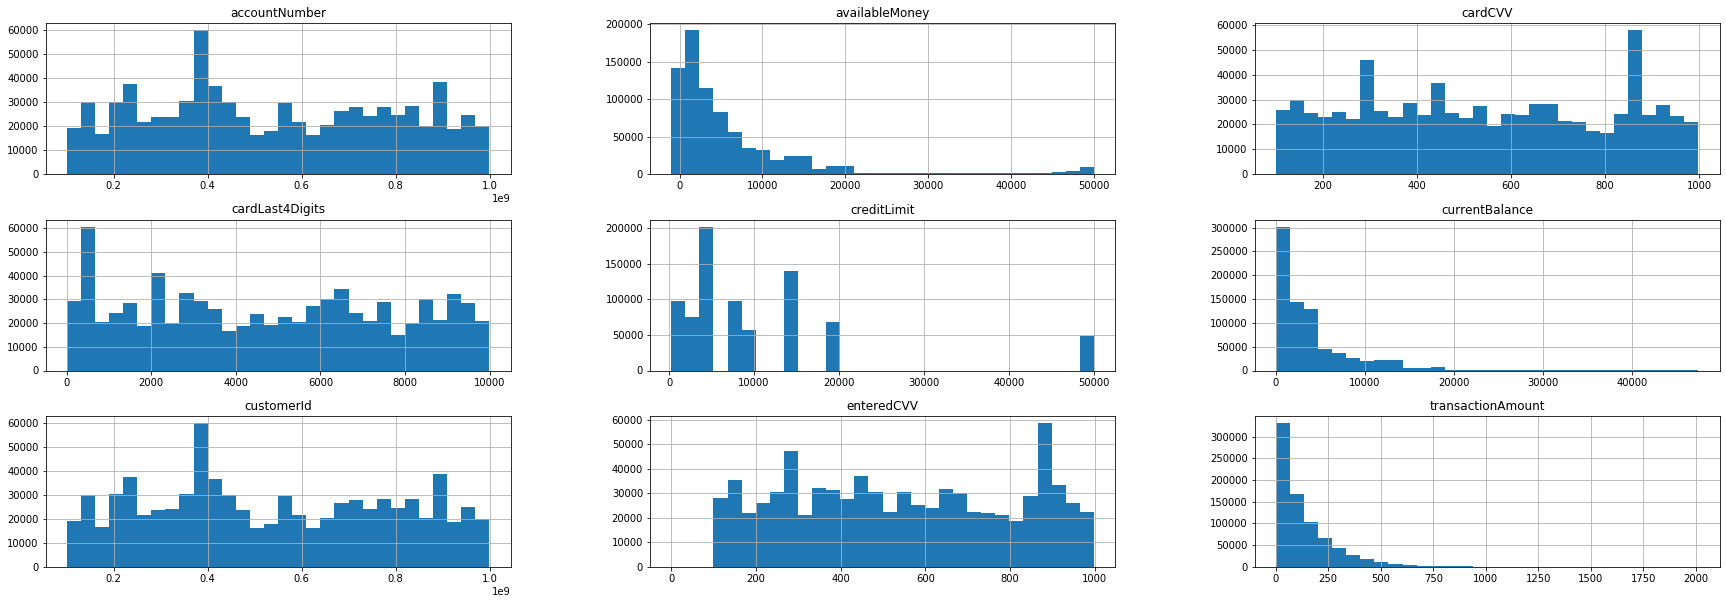

In [14]:
num_hist = plt.figure(figsize = (30, 10))
ax1 = num_hist.add_subplot(111)
trnz2.select_dtypes(include = ['int64', 'float64']).hist(ax = ax1, bins = 30);

- there are some numeric ranges that are markedly more popular like 4e8 in customerId and accountNumber but no values that are significantly farther away from the rest of the values like -9999 so we'll assume that none of the numeric values are blank
- creditLimit could potentially be treated as a categorical variable, which is something we could test and explore with more time

we'll convert the date columns to actual date values before moving forward
- transactionDateTime
- currentExpDate
- accountOpenDate
- dateOfLastAddressChange

In [15]:
trnz2[['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']].head()

,transactionDateTime,currentExpDate,accountOpenDate,dateOfLastAddressChange
0,2016-08-13T14:27:32,06/2023,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,02/2024,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,08/2025,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,08/2025,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,10/2029,2015-08-06,2015-08-06


In [16]:
trnz2['transactionDateTime_dt'] = pd.to_datetime(trnz2.transactionDateTime, format='%Y-%m-%dT%H:%M:%S')

In [17]:
trnz2['currentExpDate_dt'] = pd.to_datetime(trnz2.currentExpDate, format='%m/%Y')

In [18]:
trnz2['accountOpenDate_dt'] = pd.to_datetime(trnz2.accountOpenDate, format = '%Y-%m-%d')

In [19]:
trnz2['dateOfLastAddressChange_dt'] = pd.to_datetime(trnz2.dateOfLastAddressChange, format = '%Y-%m-%d')

confirm conversions are accurate

In [20]:
trnz2[['transactionDateTime', 'transactionDateTime_dt', 'currentExpDate', 'currentExpDate_dt', 'accountOpenDate', 'accountOpenDate_dt', 'dateOfLastAddressChange', 'dateOfLastAddressChange_dt']].head()

,transactionDateTime,transactionDateTime_dt,currentExpDate,currentExpDate_dt,accountOpenDate,accountOpenDate_dt,dateOfLastAddressChange,dateOfLastAddressChange_dt
0,2016-08-13T14:27:32,2016-08-13 14:27:32,06/2023,2023-06-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,2016-10-11 05:05:54,02/2024,2024-02-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,2016-11-08 09:18:39,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,2016-12-10 02:14:50,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,2016-03-24 21:04:46,10/2029,2029-10-01,2015-08-06,2015-08-06,2015-08-06,2015-08-06


yes, conversions look accurate, we'll proceed to question 2

# Question 2: Plot 

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
- Report any structure you find and any hypotheses you have about that structure.

In [21]:
#get upper and lower limits of transactionAmount to inform binwidth
trnz2.transactionAmount.describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

In [22]:
2050/50

41.0

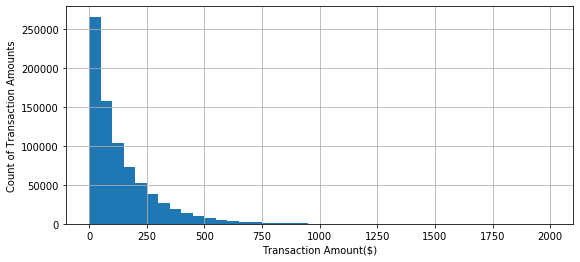

In [23]:
transplot = plt.figure(figsize = (20, 4))
ax1 = transplot.add_subplot(121)
trnz2.transactionAmount.hist(bins = range(0, 2050, 50), ax = ax1);
plt.xlabel('Transaction Amount($)');
plt.ylabel('Count of Transaction Amounts');

- the histogram of the transaction amount is right-skewed with a long right tail, following a lognormal distribution
- most of the density is for transaction amounts less than 500, which leads me to hypothesize that most of these transactions are for everyday consumer products, entertainment, travel and billpay transactions as opposed to larger transactions like rent and loan payments
- it is odd that there are transactions with a value of 0 -> could that be something that isnt actually a purchase but still counts as a "transaction"?
- because of this distribution's shape, it should transform to a relatively normal distribution if we apply the log transformation, which could help in specifying variables in our model if we use a logistic regression model
- another thing to note is that, because we'll be using this data to build a fraud model and most transactions seem like everyday purchases in that they're under \\$500, maybe the transactions over a certain dollar value, e.g. \\$1000, are more likely to be fraudulent

In [24]:
trnz2['transactionAmount_log'] = trnz2.transactionAmount.apply(lambda x: np.log(x+0.01)) #have to shift by small constant bc 0 is undefined for the log distribution

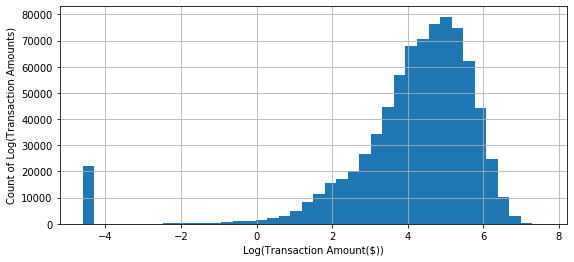

In [25]:
transplot2 = plt.figure(figsize = (20, 4))
ax1 = transplot2.add_subplot(121)
trnz2.transactionAmount_log.hist(bins = 40, ax = ax1);
plt.xlabel('Log(Transaction Amount($))');
plt.ylabel('Count of Log(Transaction Amounts)');

In [26]:
np.log(0.01)

-4.605170185988091

- the log transformed transaction amount is not quite normal and has a density below -4 corresponding to the shifted value of 0

# Question 3: Data Wrangling

- reversed transaction, where a purchase is followed by a reversal
- multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span

- Can you programmatically identify reversed and multi-swipe transactions?
- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
- Did you find anything interesting about either kind of transaction?

In [27]:
trnz2.head(2) #get column names to use in reversal and multiswipe transactions

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,2016-08-13 14:27:32,2023-06-01,2015-03-14,2015-03-14,4.590665
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,2016-10-11 05:05:54,2024-02-01,2015-03-14,2015-03-14,4.311068


In [28]:
#what is in transactionType?
trnz2.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', 'blank'],
      dtype=object)

reversal is already listed but multiswipe is not

In [29]:
# identify reversed and multiswipe transactions by sort dataset by account, customer, card, puchasetime
# if next transactionAmount is the same as the previous and from the same merchant that would mean a reversal 
# if the next transaction(s) have the same amount as the previous and is from the same merchant that would identify multi-swipe

trnz3 = trnz2.sort_values(by = ['accountNumber', 'customerId', 'cardLast4Digits', 'transactionDateTime_dt'], ascending = True).reset_index(drop = True)

In [30]:
#check range of transactionDateTime to pick value to impute nulls with
trnz3.transactionDateTime_dt.describe()

count                  786363
unique                 776637
top       2016-12-25 14:04:15
freq                        4
first     2016-01-01 00:01:02
last      2016-12-30 23:59:45
Name: transactionDateTime_dt, dtype: object

In [31]:
trnz3['accountNumber_shift'] = trnz3.accountNumber.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['customerId_shift'] = trnz3.customerId.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['cardLast4Digits_shift'] = trnz3.cardLast4Digits.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionDateTime_dt_shift'] = trnz3.transactionDateTime_dt.shift(periods = 1, axis = 'rows', fill_value = pd.to_datetime('2000-01-01 00:00:00', format = '%Y-%m-%d %H:%M:%S'))
trnz3['transactionAmount_shift'] = trnz3.transactionAmount.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionType_shift'] = trnz3.transactionType.shift(periods = 1, axis = 'rows', fill_value = 'blank')
trnz3['merchantName_shift'] = trnz3.merchantName.shift(periods = 1, axis = 'rows', fill_value = 'blank')

In [32]:
def find_duplicates(row):
    if (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'REVERSAL') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'reversed'
    elif (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'PURCHASE') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'multi_swipe'
    else:
        return 'non_duplicate'

In [33]:
trnz3['duplicateType'] = trnz3.apply(find_duplicates, axis = 1)

In [34]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

check some transactions

In [35]:
trnz3.loc[trnz3.duplicateType == 'reversed', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
399083,1144,144.85
79929,6327,444.05
439415,2194,132.33
26901,6220,83.14
572547,2036,174.88


In [36]:
trnz3.loc[ (trnz3.cardLast4Digits == 9395) & (trnz3.transactionAmount == 9.68), 
         ['duplicateType', 'accountNumber', 'accountNumber_shift', 'customerId', 'customerId_shift', 'cardLast4Digits', 'cardLast4Digits_shift', 'transactionDateTime_dt', 'transactionDateTime_dt_shift',
          'transactionType', 'transactionType_shift', 'transactionAmount', 'transactionAmount_shift', 'merchantName', 'merchantName_shift']] #looks right - same amount, same merchant, seconds from each other

,duplicateType,accountNumber,accountNumber_shift,customerId,customerId_shift,cardLast4Digits,cardLast4Digits_shift,transactionDateTime_dt,transactionDateTime_dt_shift,transactionType,transactionType_shift,transactionAmount,transactionAmount_shift,merchantName,merchantName_shift
632497,non_duplicate,810471359,810471359,810471359,810471359,9395,9395,2016-01-15 13:46:32,2016-01-15 06:48:23,PURCHASE,REVERSAL,9.68,184.26,apple.com,discount.com
632498,reversed,810471359,810471359,810471359,810471359,9395,9395,2016-01-15 13:48:44,2016-01-15 13:46:32,REVERSAL,PURCHASE,9.68,9.68,apple.com,apple.com


In [37]:
trnz3.loc[ (trnz3.cardLast4Digits == 4609) & (trnz3.transactionAmount == 62.52), 
         ['duplicateType', 'accountNumber', 'accountNumber_shift', 'customerId', 'customerId_shift', 'cardLast4Digits', 'cardLast4Digits_shift', 'transactionDateTime_dt', 'transactionDateTime_dt_shift',
          'transactionType', 'transactionType_shift', 'transactionAmount', 'transactionAmount_shift', 'merchantName', 'merchantName_shift']] #looks right - same amount, same merchant, seconds from each other

,duplicateType,accountNumber,accountNumber_shift,customerId,customerId_shift,cardLast4Digits,cardLast4Digits_shift,transactionDateTime_dt,transactionDateTime_dt_shift,transactionType,transactionType_shift,transactionAmount,transactionAmount_shift,merchantName,merchantName_shift
33901,non_duplicate,142263758,142263758,142263758,142263758,4609,4609,2016-10-17 01:15:42,2016-10-16 21:00:34,PURCHASE,PURCHASE,62.52,155.63,Next Day eCards,williamssonoma.com
33902,reversed,142263758,142263758,142263758,142263758,4609,4609,2016-10-17 01:17:07,2016-10-17 01:15:42,REVERSAL,PURCHASE,62.52,62.52,Next Day eCards,Next Day eCards


In [38]:
trnz3.loc[ (trnz3.cardLast4Digits == 4165) & (trnz3.transactionAmount == 232.20),
         ['duplicateType', 'accountNumber', 'accountNumber_shift', 'customerId', 'customerId_shift', 'cardLast4Digits', 'cardLast4Digits_shift', 'transactionDateTime_dt', 'transactionDateTime_dt_shift',
          'transactionType', 'transactionType_shift', 'transactionAmount', 'transactionAmount_shift', 'merchantName', 'merchantName_shift']] #looks right - same amount, same merchant, seconds from each other

,duplicateType,accountNumber,accountNumber_shift,customerId,customerId_shift,cardLast4Digits,cardLast4Digits_shift,transactionDateTime_dt,transactionDateTime_dt_shift,transactionType,transactionType_shift,transactionAmount,transactionAmount_shift,merchantName,merchantName_shift
758045,non_duplicate,957964653,957964653,957964653,957964653,4165,4165,2016-10-04 18:42:28,2016-09-23 23:45:48,PURCHASE,PURCHASE,232.2,58.97,walmart.com,Sunoco Gas #316345
758046,reversed,957964653,957964653,957964653,957964653,4165,4165,2016-10-04 18:43:58,2016-10-04 18:42:28,REVERSAL,PURCHASE,232.2,232.20,walmart.com,walmart.com


reversed transactions look right so now lets check multi_swipe

In [39]:
trnz3.loc[trnz3.duplicateType == 'multi_swipe', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
613721,7462,43.84
419429,1421,1.86
155289,7302,3.01
480221,4786,3.36
543872,5646,45.94


In [40]:
trnz3.loc[ (trnz3.cardLast4Digits == 9685) & (trnz3.transactionAmount == 113.57),
         ['duplicateType', 'accountNumber', 'accountNumber_shift', 'customerId', 'customerId_shift', 'cardLast4Digits', 'cardLast4Digits_shift', 'transactionDateTime_dt', 'transactionDateTime_dt_shift',
          'transactionType', 'transactionType_shift', 'transactionAmount', 'transactionAmount_shift', 'merchantName', 'merchantName_shift']] #looks right - same amount, same merchant, seconds from each other

,duplicateType,accountNumber,accountNumber_shift,customerId,customerId_shift,cardLast4Digits,cardLast4Digits_shift,transactionDateTime_dt,transactionDateTime_dt_shift,transactionType,transactionType_shift,transactionAmount,transactionAmount_shift,merchantName,merchantName_shift
208151,non_duplicate,346419123,346419123,346419123,346419123,9685,9685,2016-02-01 21:54:38,2016-01-31 17:26:20,PURCHASE,REVERSAL,113.57,3.56,Starbucks #516830,discount.com
208152,multi_swipe,346419123,346419123,346419123,346419123,9685,9685,2016-02-01 21:57:16,2016-02-01 21:54:38,PURCHASE,PURCHASE,113.57,113.57,Starbucks #516830,Starbucks #516830
208153,multi_swipe,346419123,346419123,346419123,346419123,9685,9685,2016-02-01 21:58:18,2016-02-01 21:57:16,PURCHASE,PURCHASE,113.57,113.57,Starbucks #516830,Starbucks #516830


In [41]:
trnz3.loc[ (trnz3.cardLast4Digits == 9102) & (trnz3.transactionAmount == 151.64),
         ['duplicateType', 'accountNumber', 'accountNumber_shift', 'customerId', 'customerId_shift', 'cardLast4Digits', 'cardLast4Digits_shift', 'transactionDateTime_dt', 'transactionDateTime_dt_shift',
          'transactionType', 'transactionType_shift', 'transactionAmount', 'transactionAmount_shift', 'merchantName', 'merchantName_shift']] #looks right - same amount, same merchant, seconds from each other

,duplicateType,accountNumber,accountNumber_shift,customerId,customerId_shift,cardLast4Digits,cardLast4Digits_shift,transactionDateTime_dt,transactionDateTime_dt_shift,transactionType,transactionType_shift,transactionAmount,transactionAmount_shift,merchantName,merchantName_shift
714068,non_duplicate,894938833,894938833,894938833,894938833,9102,9102,2016-12-12 11:00:25,2016-12-12 10:38:19,PURCHASE,PURCHASE,151.64,377.18,Walgreens #808671,NYSC #331326
714069,multi_swipe,894938833,894938833,894938833,894938833,9102,9102,2016-12-12 11:01:18,2016-12-12 11:00:25,PURCHASE,PURCHASE,151.64,151.64,Walgreens #808671,Walgreens #808671


### estimated total number of reversed and multi-swipe transactions

In [42]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

### 5,502 reversed transactions, 7,342 multi-swipe transactions

### estimated dollar amounts for reversed and multi_swipe transactions

In [43]:
trnz3.groupby('duplicateType')['transactionAmount'].sum().apply(lambda x: '${:,.2f}'.format(x))

duplicateType
multi_swipe        $1,087,165.85
non_duplicate    $105,808,565.16
reversed             $824,826.52
Name: transactionAmount, dtype: object

### \\$824K in reversed transactions and \\$1.08M for multi swipe transactions

is there anything interesting about the reversed and multi-swipe transactions relative to the non-duplicate transactions?
- transactionAmount?
- particular merchant categories?
- particular days?
- merchant locations?

duplicateType x transactionAmount

In [44]:
trnz3.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'transactionDateTime_dt',
       'currentExpDate_dt', 'accountOpenDate_dt', 'dateOfLastAddressChange_dt',
       'transactionAmount_log', 'accountNumber_shift', 'customerId_shift',
       'cardLast4Digits_shift', 'transactionDateTime_dt_shift',
       'transactionAmount_shift', 'transactionType_shift',
       'merchantName_shift', 'duplicateType'],
      dtype='object')

In [45]:
merch_dup_agg = trnz3.groupby(['merchantName', 'duplicateType']).size().reset_index()
merch_dup_agg.columns = ['merchantName', 'duplicateType', 'count']
merch_dup_pvt = merch_dup_agg.pivot_table(values = 'count', index = 'merchantName', columns = 'duplicateType', fill_value = 0).reset_index()
merch_dup_pvt['total_count'] = merch_dup_pvt.multi_swipe + merch_dup_pvt.non_duplicate + merch_dup_pvt.reversed
merch_dup_pvt['pct_reversed'] = merch_dup_pvt.reversed / merch_dup_pvt.total_count
merch_dup_pvt['pct_multi_swipe'] = merch_dup_pvt.multi_swipe / merch_dup_pvt.total_count
merch_dup_pvt['pct_duplicate'] = (merch_dup_pvt.reversed + merch_dup_pvt.multi_swipe) / merch_dup_pvt.total_count

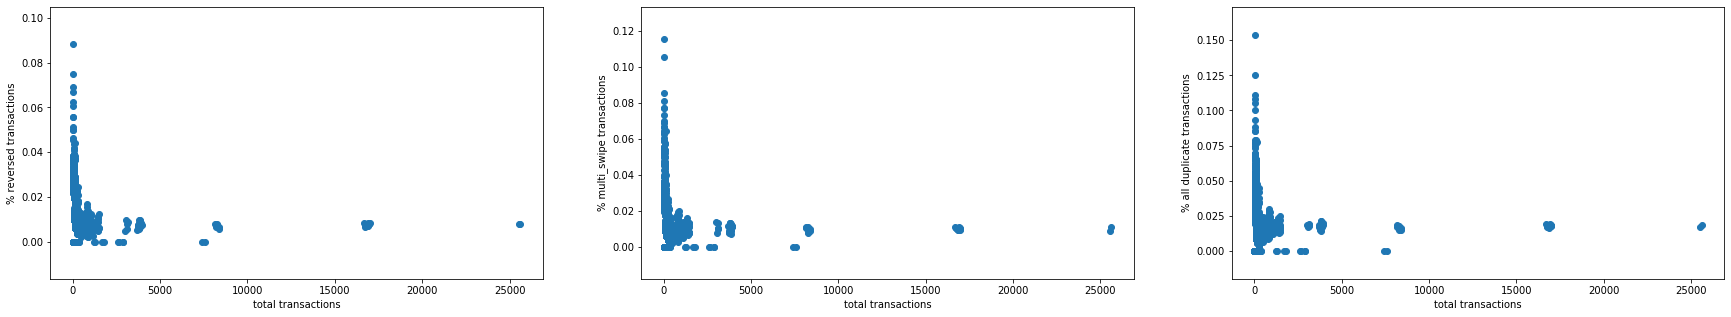

In [46]:
dup_fig = plt.figure(figsize = (30, 5))
ax1 = dup_fig.add_subplot(131)
plt.scatter(merch_dup_pvt.total_count, merch_dup_pvt.pct_reversed)
plt.xlabel('total transactions')
plt.ylabel('% reversed transactions');

ax2 = dup_fig.add_subplot(132)
plt.scatter(merch_dup_pvt.total_count, merch_dup_pvt.pct_multi_swipe)
plt.xlabel('total transactions')
plt.ylabel('% multi_swipe transactions');

ax3 = dup_fig.add_subplot(133)
plt.scatter(merch_dup_pvt.total_count, merch_dup_pvt.pct_duplicate)
plt.xlabel('total transactions')
plt.ylabel('% all duplicate transactions');

- because the percentage of reversed, multi-swipe and duplicate transactions is only higher for merchants with less transactions and rarely above 10%, there doesn't appear to be a subset of merchants with an exceptionally high percentage of reversed or duplicate transactions
- there are some merchants without any duplicate or multi-swipe transactions -> who are they?

In [47]:
merch_dup_pvt.loc[ (merch_dup_pvt.pct_duplicate == 0) & (merch_dup_pvt.total_count >= 200)]

duplicateType,merchantName,multi_swipe,non_duplicate,reversed,total_count,pct_reversed,pct_multi_swipe,pct_duplicate
43,Apple iTunes,0,7571,0,7571,0.0,0.0,0.0
341,Daily Fresh,0,1237,0,1237,0.0,0.0,0.0
342,DailyOmnivore,0,1787,0,1787,0.0,0.0,0.0
684,GreenCook,0,1673,0,1673,0.0,0.0,0.0
1108,Mobil Gas #194289,0,207,0,207,0.0,0.0,0.0
1109,Mobil Gas #235527,0,255,0,255,0.0,0.0,0.0
1111,Mobil Gas #281388,0,223,0,223,0.0,0.0,0.0
1122,Mobil Gas #841292,0,304,0,304,0.0,0.0,0.0
1123,Mobil Gas #851671,0,247,0,247,0.0,0.0,0.0
1125,Mobil Gas #864408,0,332,0,332,0.0,0.0,0.0


In [48]:
trnz3.groupby('duplicateType')['transactionAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
duplicateType,,,,,,,,
multi_swipe,7342.0,148.074891,147.997143,0.01,41.5725,101.265,205.810,1394.19
non_duplicate,773519.0,136.788579,147.675165,0.00,33.5400,87.650,191.230,2011.54
reversed,5502.0,149.913944,153.233509,0.09,41.0700,104.305,204.295,1338.25


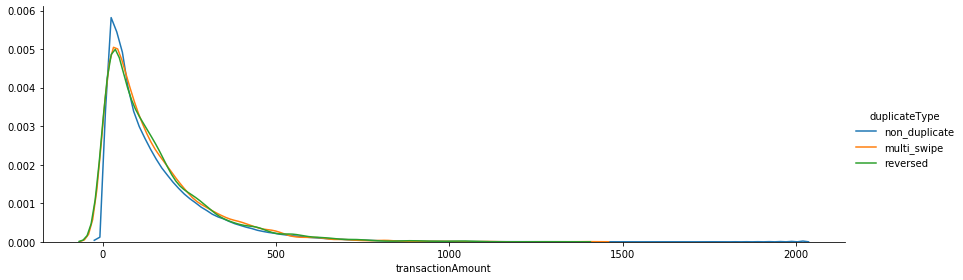

In [49]:
dup_amt = sns.FacetGrid(data = trnz3, hue = 'duplicateType', sharex = True, sharey = False, height = 4, aspect = 3)
dup_amt = dup_amt.map(sns.kdeplot, 'transactionAmount').add_legend();

- mean transaction amounts for reversed and multi_swipe transactions are a little higher but this doesnt look to be a significant difference and not one that we would expect -> we could do a formal non-parametric kruskall wallis test but that seems unnecessary here because we're just doing some exploration

merchant types

In [50]:
merch_cat_agg = trnz3.groupby(['merchantCategoryCode', 'duplicateType']).size().reset_index()
merch_cat_agg.columns = ['merchantCategoryCode', 'duplicateType', 'count']
merch_cat_pvt = merch_cat_agg.pivot_table(values = 'count', index = 'merchantCategoryCode', columns = 'duplicateType', fill_value = 0).reset_index()
merch_cat_pvt['total_count'] = merch_cat_pvt.multi_swipe + merch_cat_pvt.non_duplicate + merch_cat_pvt.reversed
merch_cat_pvt['pct_reversed'] = merch_cat_pvt.reversed / merch_cat_pvt.total_count
merch_cat_pvt['pct_multi_swipe'] = merch_cat_pvt.multi_swipe / merch_cat_pvt.total_count
merch_cat_pvt['pct_duplicate'] = (merch_cat_pvt.reversed + merch_cat_pvt.multi_swipe) / merch_cat_pvt.total_count

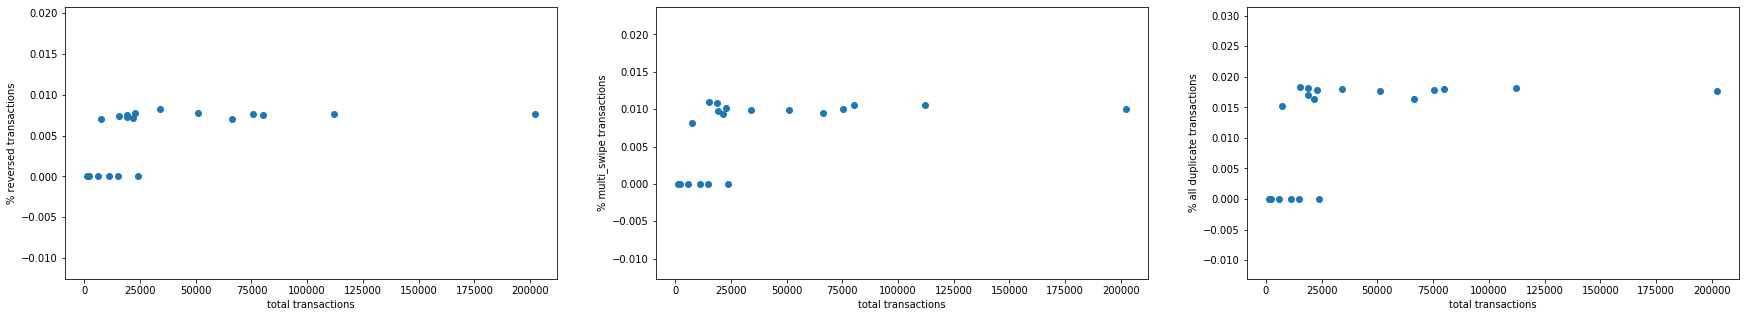

In [51]:
dup_fig2 = plt.figure(figsize = (30, 5))
ax1 = dup_fig2.add_subplot(131)
plt.scatter(merch_cat_pvt.total_count, merch_cat_pvt.pct_reversed)
plt.xlabel('total transactions')
plt.ylabel('% reversed transactions');

ax2 = dup_fig2.add_subplot(132)
plt.scatter(merch_cat_pvt.total_count, merch_cat_pvt.pct_multi_swipe)
plt.xlabel('total transactions')
plt.ylabel('% multi_swipe transactions');

ax3 = dup_fig2.add_subplot(133)
plt.scatter(merch_cat_pvt.total_count, merch_cat_pvt.pct_duplicate)
plt.xlabel('total transactions')
plt.ylabel('% all duplicate transactions');

In [52]:
merch_cat_pvt.loc[ merch_cat_pvt.pct_duplicate == 0]

duplicateType,merchantCategoryCode,multi_swipe,non_duplicate,reversed,total_count,pct_reversed,pct_multi_swipe,pct_duplicate
2,cable/phone,0,1382,0,1382,0.0,0.0,0.0
6,food_delivery,0,6000,0,6000,0.0,0.0,0.0
7,fuel,0,23910,0,23910,0.0,0.0,0.0
9,gym,0,2209,0,2209,0.0,0.0,0.0
12,mobileapps,0,14990,0,14990,0.0,0.0,0.0
15,online_subscriptions,0,11067,0,11067,0.0,0.0,0.0


there dont appear to be any patterns of duplicate or multi-swipe transactions occurring more often at particular kinds of merchants but it is interesting that these entire categories of merchants - cable/phone, food_delivery, fuel, gym, mobileapps and online_subscriptions don't have any duplicate transactions
    - gym, cable/phone and online_subscriptions are largely subscription services with most transactions likely automated, recurring transactions with the cardholder's card attributes
    - mobileapps and food_delivery are likely similar in that they have card information saved for future transactions
    - why fuel has no multi_swipe or duplicate transactions is odd because i would assume most if not all people are entering and removing their card for fuel purchases, unless a large portion or all of these transactions are done via the card stored on a user's phone?

lets check days or hours of the day for patterns of more duplicate transactions, i.e. at the end of the week or day are reversed or multi_swipe transactions more prevalent?

In [53]:
wkday_dict = {0:'Mon', 1:'Tues', 2:'Weds', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}
trnz3['trns_weekday'] = pd.Categorical(trnz3.transactionDateTime_dt.dt.date.apply(lambda x: x.weekday()).map(wkday_dict), 
                                       categories = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'], ordered = True)
trnz3['trns_hr'] = trnz3.transactionDateTime_dt.dt.hour

In [54]:
wkday_agg = trnz3.groupby(['trns_weekday', 'duplicateType']).size().reset_index()
wkday_agg.columns = ['trns_weekday', 'duplicateType', 'count']
wkday_pvt = wkday_agg.pivot_table(values = 'count', index = 'trns_weekday', columns = 'duplicateType', fill_value = 0).reset_index()
wkday_pvt['total_count'] = wkday_pvt.multi_swipe + wkday_pvt.non_duplicate + wkday_pvt.reversed
wkday_pvt['pct_reversed'] = wkday_pvt.reversed / wkday_pvt.total_count
wkday_pvt['pct_multi_swipe'] = wkday_pvt.multi_swipe / wkday_pvt.total_count
wkday_pvt['pct_duplicate'] = (wkday_pvt.reversed + wkday_pvt.multi_swipe) / wkday_pvt.total_count

In [55]:
wkday_pvt

duplicateType,trns_weekday,multi_swipe,non_duplicate,reversed,total_count,pct_reversed,pct_multi_swipe,pct_duplicate
0,Mon,1068,109777,778,111623,0.006970,0.009568,0.016538
1,Tues,1038,110516,733,112287,0.006528,0.009244,0.015772
2,Weds,1024,110174,813,112011,0.007258,0.009142,0.016400
3,Thurs,1044,110271,789,112104,0.007038,0.009313,0.016351
4,Fri,1056,112866,820,114742,0.007146,0.009203,0.016350
5,Sat,1051,110233,803,112087,0.007164,0.009377,0.016541
6,Sun,1061,109682,766,111509,0.006869,0.009515,0.016384


In [56]:
hr_agg = trnz3.groupby(['trns_hr', 'duplicateType']).size().reset_index()
hr_agg.columns = ['trns_hr', 'duplicateType', 'count']
hr_pvt = hr_agg.pivot_table(values = 'count', index = 'trns_hr', columns = 'duplicateType', fill_value = 0).reset_index()
hr_pvt['total_count'] = hr_pvt.multi_swipe + hr_pvt.non_duplicate + hr_pvt.reversed
hr_pvt['pct_reversed'] = hr_pvt.reversed / hr_pvt.total_count
hr_pvt['pct_multi_swipe'] = hr_pvt.multi_swipe / hr_pvt.total_count
hr_pvt['pct_duplicate'] = (hr_pvt.reversed + hr_pvt.multi_swipe) / hr_pvt.total_count

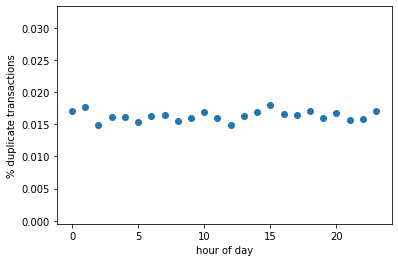

In [57]:
plt.scatter(hr_pvt.trns_hr, hr_pvt.pct_duplicate);
plt.xlabel('hour of day')
plt.ylabel('% duplicate transactions');

duplicate transactions dont have any pattern across weekdays or hours as they are uniformly distributed across days of the week for each transaction type

merchant geographies

In [58]:
dup_geo_df = trnz3.groupby(['duplicateType', 'merchantCountryCode']).size().reset_index()
dup_geo_df.columns = ['duplicateType', 'merchantCountryCode', 'transactions']

In [59]:
dup_geo_total = trnz3.groupby('duplicateType').size().reset_index()
dup_geo_total.columns = ['duplicateType', 'totalTransactions']

In [60]:
dup_geo_df2 = dup_geo_df.merge(dup_geo_total, on = 'duplicateType', how = 'inner')

In [61]:
dup_geo_df2['country_pct_transactions'] = np.round(dup_geo_df2.transactions / dup_geo_df2.totalTransactions, 3)

In [62]:
dup_geo_df2

,duplicateType,merchantCountryCode,transactions,totalTransactions,country_pct_transactions
0,multi_swipe,CAN,20,7342,0.003
1,multi_swipe,MEX,30,7342,0.004
2,multi_swipe,PR,11,7342,0.001
3,multi_swipe,US,7280,7342,0.992
4,multi_swipe,blank,1,7342,0.000
5,non_duplicate,CAN,2381,773519,0.003
6,non_duplicate,MEX,3083,773519,0.004
7,non_duplicate,PR,1537,773519,0.002
8,non_duplicate,US,765799,773519,0.990
9,non_duplicate,blank,719,773519,0.001


- there doesnt appear to be a notable relationship between merchantCountry and duplicate transactions either
- therefore, if there is an interesting relationship with duplicate transaction types we'd have to do more research to find it

# Question 4: Model

- Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
- Provide an estimate of performance using an appropriate sample, and show your work.
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

Approach: assuming that this is a predictive model whose predictive performance outweighs interpreting coefficients to make recommendations related to variables in the model, particularly because fraud is the use-case, we'll fit a couple models to compare their performance
1. separate into training and test set - training to build the model and test to compare out-of-sample predictive performance
2. make some derived variables
3. perform some exploratory data analysis on explanatory variables as well as their relationship with the response
#### modeling algorithm/used and why
4. modelling
    - fit a couple models with different parameterizations and objective functions because it is hard to understand how these variables are represented in high dimensions and in combination with each other outside of fitting the model
        - regularized logistic regression for linear parameterization of explanatory variables and regularization
        - gradient boosted tree for tree structure and boosting capability to improve model based on misclassified cases
        - naive bayes for bayesian parameterization assuming conditional independence 

5. score models on test set and compare performance

#### 1. train and test split - 85/15 assuming that fraud will be a rare event to have enough cases in the training set to build model and relatively small test set

In [63]:
trnz3['ran_num'] = np.random.uniform(low = 0, high = 1, size = trnz3.shape[0])
trnz3['train_test'] = np.where(trnz3.ran_num >= 0.15, 'train', 'test')

In [64]:
trn = trnz3.loc[ trnz3.train_test == 'train']

In [65]:
#proportion of fraudulent cases in training set
np.round(trn.isFraud.value_counts(dropna = False) / trn.shape[0], 3)

False    0.984
True     0.016
Name: isFraud, dtype: float64

1.6% of rows is fraudulent in the training set

#### 2. make some derived variables

In [66]:
trn.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType,trns_weekday,trns_hr,ran_num,train_test
0,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,01,online_gifts,11/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,251.56,False,False,False,2016-01-17 15:41:46,2031-11-01,2014-01-09,2014-01-09,5.936692,-99,-99,-99,2000-01-01 00:00:00,-99.00,blank,blank,non_duplicate,Sun,15,0.423374,train
1,100088067,100088067,50000,49792.33,2016-02-08T06:09:12,259.44,Blue Mountain eCards,US,US,05,01,online_gifts,01/2028,2014-01-09,2014-01-09,402,402,2077,PURCHASE,207.67,False,False,False,2016-02-08 06:09:12,2028-01-01,2014-01-09,2014-01-09,5.558564,100088067,100088067,2077,2016-01-17 15:41:46,378.67,PURCHASE,Mobile eCards,non_duplicate,Mon,6,0.552321,train
2,100088067,100088067,50000,49532.89,2016-02-09T18:36:53,32.50,EZ Putt Putt #804489,US,US,09,01,entertainment,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,467.11,True,False,False,2016-02-09 18:36:53,2026-07-01,2014-01-09,2014-01-09,3.481548,100088067,100088067,2077,2016-02-08 06:09:12,259.44,PURCHASE,Blue Mountain eCards,non_duplicate,Tues,18,0.960099,train
4,100088067,100088067,50000,49923.92,2016-03-12T12:55:28,97.79,Dinosaur Sandwitch Bar #960325,US,US,05,01,food,01/2032,2014-01-09,2014-01-09,402,402,2077,PURCHASE,76.08,True,False,False,2016-03-12 12:55:28,2032-01-01,2014-01-09,2014-01-09,4.582925,100088067,100088067,2077,2016-02-13 20:17:41,56.05,PURCHASE,Fresh Flowers,non_duplicate,Sat,12,0.313109,train
7,100088067,100088067,50000,49758.31,2016-05-16T20:33:00,71.41,Next Day eCards,US,US,05,01,online_gifts,08/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,241.69,False,False,False,2016-05-16 20:33:00,2031-08-01,2014-01-09,2014-01-09,4.268578,100088067,100088067,2077,2016-04-01 04:47:33,46.19,PURCHASE,Fresh Online Services,non_duplicate,Mon,20,0.697696,train


what do the values in acqCountry and merchantCountyCode look like?

In [67]:
trn.acqCountry.value_counts(dropna = False)

US       658062
blank      3855
MEX        2661
CAN        2092
PR         1322
Name: acqCountry, dtype: int64

In [68]:
trn.merchantCountryCode.value_counts(dropna = False)

US       661270
MEX        2673
CAN        2092
PR         1337
blank       620
Name: merchantCountryCode, dtype: int64

- % creditUtilization = cardBalance / creditLimit
- acq country = merchant country
- time since account open
- time since last address change (potentially last time account information was updated, potentially including security settings like password making fraud harder)
- cardCVV = enteredCVV
- transaction month

In [69]:
trn['creditUtil'] = trn.currentBalance / trn.creditLimit
trn['acqEqMerchCountry'] = np.where(trn.acqCountry == trn.merchantCountryCode, 'Yes', 'No')
trn['daysSinceAcctOpen'] = (trn.transactionDateTime_dt.dt.date - trn.accountOpenDate_dt.dt.date).dt.days
trn['daysSinceAddressChange'] = (trn.transactionDateTime_dt.dt.date - trn.dateOfLastAddressChange_dt.dt.date).dt.days
trn['cvvEqual'] = np.where(trn.cardCVV == trn.enteredCVV, 'Yes' ,'No')

#map months to categories so categorical representation is used instead of continuous in the model
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
trn['transactionMonth'] = pd.Categorical(trn.transactionDateTime_dt.apply(lambda x: x.month).map(month_dict),
                                         categories = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)

#### 3. do some exploratory data analysis on individual variables and derived variables vs the response variable

In [70]:
trn.isFraud.unique()

array([False,  True])

In [71]:
# create response variable for model
trn['fraud'] = np.where(trn.isFraud == True, 1, 0)

continuous variables first

In [72]:
trn.dtypes

accountNumber                            int64
customerId                               int64
creditLimit                              int64
availableMoney                         float64
transactionDateTime                     object
transactionAmount                      float64
merchantName                            object
acqCountry                              object
merchantCountryCode                     object
posEntryMode                            object
posConditionCode                        object
merchantCategoryCode                    object
currentExpDate                          object
accountOpenDate                         object
dateOfLastAddressChange                 object
cardCVV                                  int64
enteredCVV                               int64
cardLast4Digits                          int64
transactionType                         object
currentBalance                         float64
cardPresent                               bool
expirationDat

In [73]:
trn.select_dtypes(include = ['int64', 'float64']).columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'currentBalance', 'transactionAmount_log', 'accountNumber_shift',
       'customerId_shift', 'cardLast4Digits_shift', 'transactionAmount_shift',
       'trns_hr', 'ran_num', 'creditUtil', 'daysSinceAcctOpen',
       'daysSinceAddressChange'],
      dtype='object')

In [74]:
cont_desc_df = trn.groupby('isFraud')['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange'].describe().stack().reset_index()
cont_desc_df.columns = ['isFraud', 'stat', 'creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange']
cont_desc_df.sort_values(by = ['stat', 'isFraud'])

,isFraud,stat,creditLimit,availableMoney,transactionAmount,currentBalance,transactionAmount_log,trns_hr,creditUtil,daysSinceAcctOpen,daysSinceAddressChange
4,False,25%,5000.000000,1075.500000,33.150000,686.810000,3.501344,6.000000,0.172352,430.000000,29.000000
12,True,25%,5000.000000,1074.350000,86.030000,820.420000,4.454812,6.000000,0.195885,427.000000,23.000000
5,False,50%,7500.000000,3185.540000,86.730000,2443.120000,4.462915,12.000000,0.472600,680.000000,160.000000
13,True,50%,7500.000000,3117.920000,176.710000,2729.900000,5.174567,11.000000,0.493772,668.000000,126.000000
6,False,75%,15000.000000,7500.000000,189.520000,5282.765000,5.244547,18.000000,0.730950,1111.000000,613.000000
14,True,75%,15000.000000,7500.000000,311.180000,5498.600000,5.740404,17.000000,0.744874,1009.000000,556.000000
0,False,count,657423.000000,657423.000000,657423.000000,657423.000000,657423.000000,657423.000000,657423.000000,657423.000000,657423.000000
8,True,count,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000
7,False,max,50000.000000,50000.000000,2011.540000,47498.810000,7.606661,23.000000,4.722200,9990.000000,9990.000000
15,True,max,50000.000000,50000.000000,1608.350000,47344.670000,7.382970,23.000000,3.457560,9890.000000,9890.000000


- mean transaction amounts are higher for fraud, but maximum is lower and standard deviation is higher -> interesting, doesn't necessarily suggest a linear relationship
- days since account open is slightly less the fraud transactions
- some difference between means in daysSinceAddressChange
- other variables variables dont reveal much difference in distribution between fraudulent transactions and not

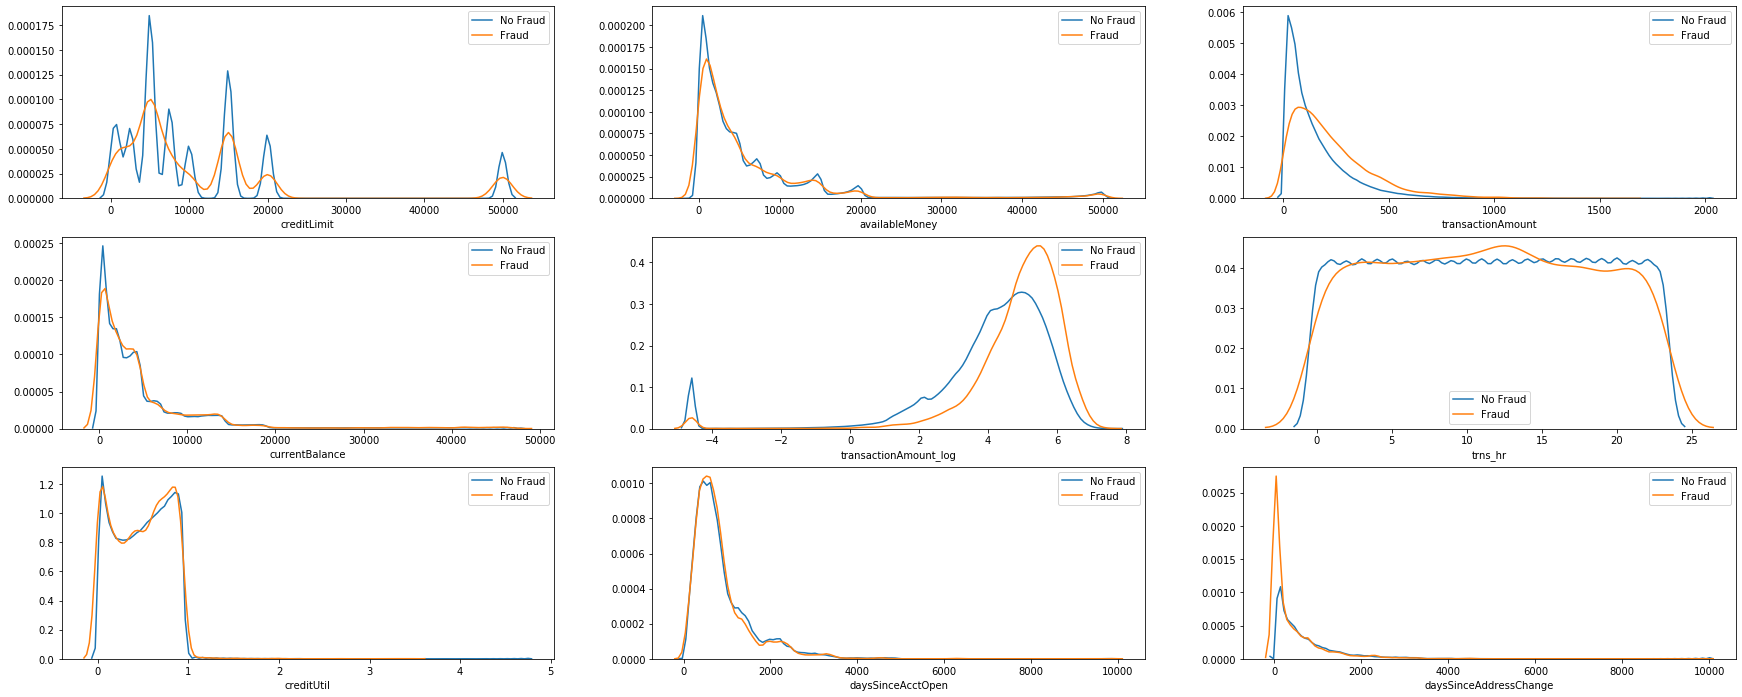

In [75]:
#continuous variables vs isFraud - 
cont_vars = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 
    'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange']

cont_fig = plt.figure(figsize = (30, 12))

for c in cont_vars:

    ax = cont_fig.add_subplot(3,3,(cont_vars.index(c) + 1))
    sns.distplot(trn.loc[ trn.fraud == 0, c], label = 'No Fraud', hist = False)
    sns.distplot(trn.loc[ trn.fraud == 1, c], label = 'Fraud', hist = False)
    plt.legend();

- similar to the summary statistics we saw above, transactionAmount and transactionAmoung_log show some differences in their distribution
- another variable whose distribution is slightly different by fraud/no fraud is trns_hr (hour of transaction), which shows slightly more central tendency for fraudulent transactions than non-fraudulent around hour 12-13 whereas non-fraudulent transactions have a virtually uniform distribution
#### - therefore, transactionAmount and hour of transaction appear to be useful for predicting fraudulent cases

categorical variables versus fraud

In [76]:
trn.select_dtypes(include = ['O', 'category']).columns

Index(['transactionDateTime', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'transactionType', 'transactionType_shift',
       'merchantName_shift', 'duplicateType', 'trns_weekday', 'train_test',
       'acqEqMerchCountry', 'cvvEqual', 'transactionMonth'],
      dtype='object')

merchantName has over 2K values so examine this separately with summary statistics

In [77]:
merchName_agg = trn.groupby(['merchantName', 'isFraud']).size().reset_index()
merchName_agg.columns = ['merchantName', 'isFraud', 'count']
merchName_pvt = merchName_agg.pivot_table(values = 'count', index = 'merchantName', columns = 'isFraud', fill_value = 0).reset_index()
merchName_pvt.columns = ['merchantName', 'NotFraud_count', 'Fraud_count']
merchName_pvt['total_count'] = merchName_pvt.Fraud_count + merchName_pvt.NotFraud_count
merchName_pvt['pct_fraud'] = merchName_pvt.Fraud_count / merchName_pvt.total_count

In [78]:
merchName_pvt.head()

,merchantName,NotFraud_count,Fraud_count,total_count,pct_fraud
0,1st BBQ,706,10,716,0.013966
1,1st Deli,683,4,687,0.005822
2,1st Pub,670,19,689,0.027576
3,1st Restaurant,695,9,704,0.012784
4,1st Sandwitch Bar #119707,646,8,654,0.012232


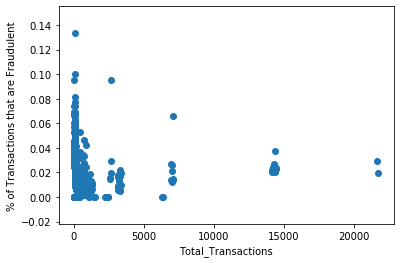

In [79]:
plt.scatter(merchName_pvt.total_count, merchName_pvt.pct_fraud);
plt.xlabel('Total_Transactions');
plt.ylabel('% of Transactions that are Fraudulent');

because there aren't merchants that appear to have a notably higher percentage of fraudulent transactions (i.e. > 10%) that also have a significant number of transactions (i.e. > 1000) and there are 2K+ levels of this variable, including it in the model would lead to significantly more processing time to create all of the indicator variables for the model, so we'll exclude it from the model

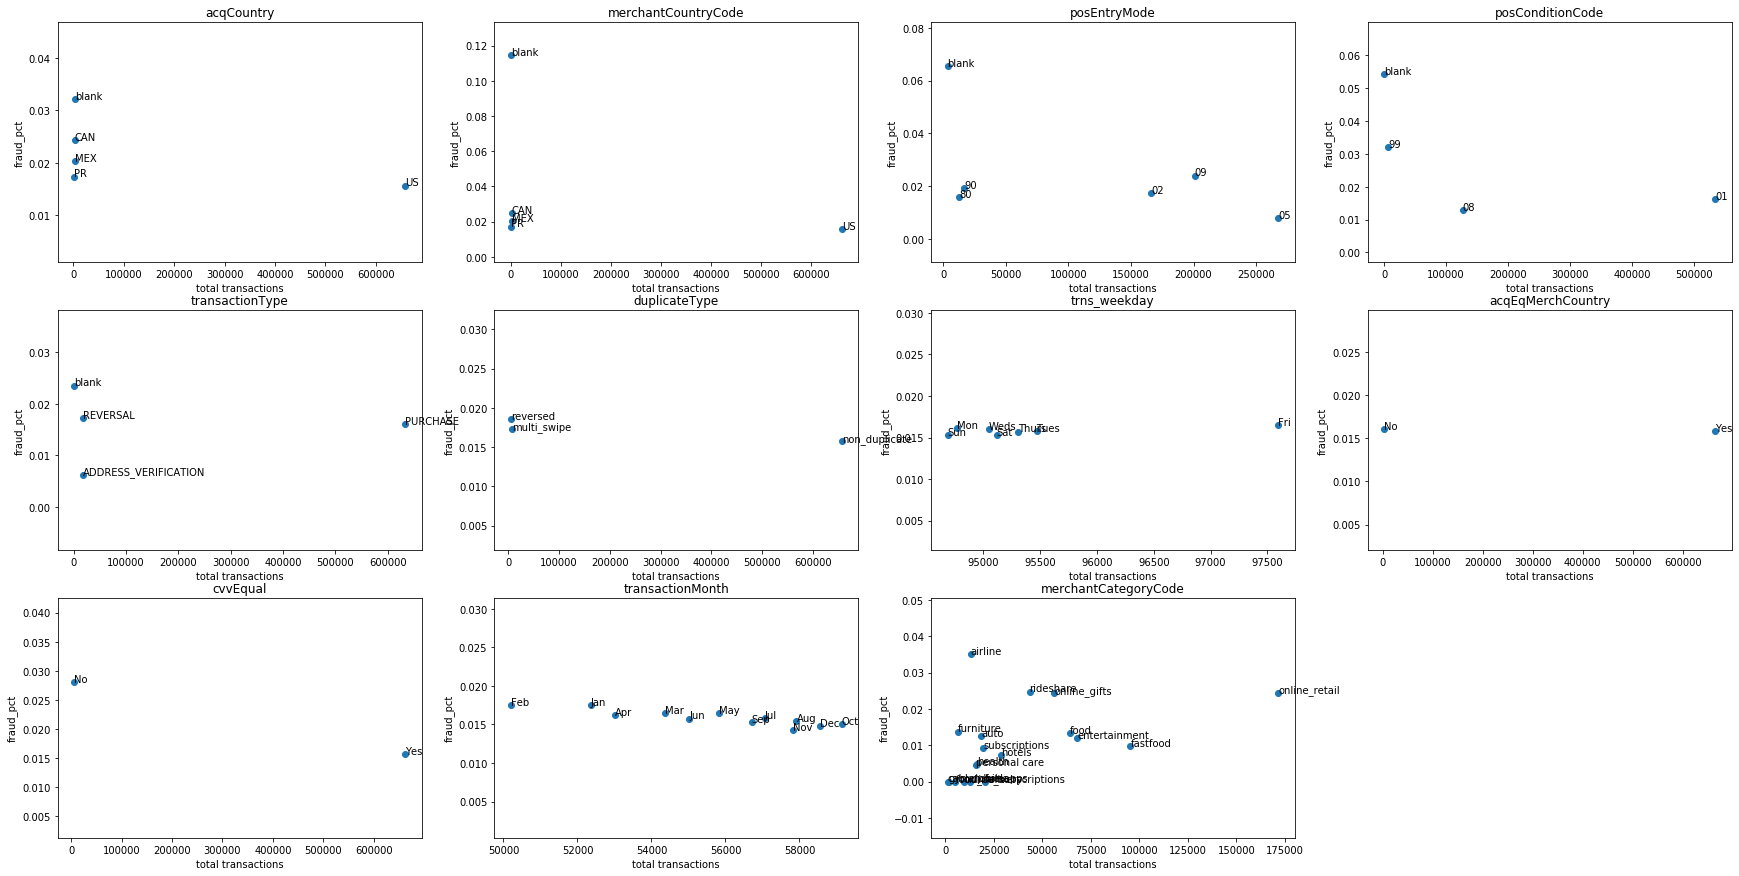

In [80]:
#scatterplot with text annotation - https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
cat_vars = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'duplicateType', 
            'trns_weekday', 'acqEqMerchCountry', 'cvvEqual', 'transactionMonth', 'merchantCategoryCode']

cat_fig = plt.figure(figsize = (30, 15))

for c in cat_vars:
    
    test_df = pd.crosstab(trn[c], trn.fraud).reset_index()
    test_df.columns = [c, 'nofraud', 'fraud']
    test_df['total_transactions'] = test_df.nofraud + test_df.fraud
    test_df['fraud_pct'] =  test_df.fraud / test_df.total_transactions
      
    ax = cat_fig.add_subplot(3,4,(cat_vars.index(c)+1))
    plt.scatter(test_df.total_transactions, test_df.fraud_pct)
    plt.title(c);
    plt.xlabel('total transactions');
    plt.ylabel('fraud_pct');

    for i, txt in enumerate(test_df[c]):
        plt.annotate(txt, (test_df.total_transactions[i], test_df.fraud_pct[i]))

#### - there are plenty of interesting differences among categorical variables
- blank values have a notably (maybe significant, maybe not) higher percentage of fraudulent transactions within acqCountry, merchantCountryCode, posEntryMode, posConditionCode and transactionType, which isn't surprising
- instances where the acquisition country doesnt equal the merchant country doesnt lead to a higher percentage of fraudulent transactions
- instances where the cvv isnt equal has a likelihood of being fraudulent twice as much as not fraudulent, though the number of transactions is much smaller
- airlines, mobileapps, online_gifts, online_retail and rideshare have notably higher percentages of fraudulent transactions as well

#### - day of week, month and duplicate type dont appear to have notable differences in percentage of fraudulent transactions

#### what questions do you have?
- what do the different values of posEntryModel delineate?
- what do the different values of posConditionCode encompass?
- how is a transaction reported to be fraudulent? 
- how was this sample of transactions chosen to build the model?

### 4. model fitting

- a. penalized logistic regression
- b. gradient boosted tree
- c. naive bayes

In [81]:
xvars = ['creditLimit', 'availableMoney', 'transactionAmount', 'acqCountry', 'merchantCountryCode',
            'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType', 'currentBalance',
            'cardPresent', 'transactionAmount_log', 'duplicateType', 'trns_weekday', 'trns_hr', 'creditUtil', 
            'acqEqMerchCountry', 'daysSinceAcctOpen', 'daysSinceAddressChange', 'cvvEqual', 'transactionMonth']

In [82]:
#setup design matrices for training set - because we're not concerned with multicollinearity and interpretability of coefficients we'll put all of the variables in the model
y_trn, X_trn = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = trn)

regularized logistic regression

In [83]:
#setup regularized logistic regression model per scikit-learn
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#l2 because not interested in lasso-like regularization for variable selection with l1
#balanced class weights to accomodate for rare fraud event

logreg = LogisticRegression(penalty = 'l2', tol = 0.001, fit_intercept = True, class_weight = 'balanced',
                                                 solver = 'lbfgs', max_iter = 100, warm_start = False).fit(X_trn, y_trn)

get balanced positive weight to use same weight in logistic regression and xgboost

In [84]:
pos_weight = trn.fraud.value_counts()[0]/trn.fraud.value_counts()[1]
pos_weight

62.2029520295203

gradient boosted tree

In [85]:
#randomly split training set into 85/15 for boosting within training set

trn['ran_num2'] = np.random.uniform(low = 0, high = 1, size = trn.shape[0])
trn_xgb_trn = trn[ trn.ran_num2 <= 0.85 ]
trn_xgb_eval = trn[ trn.ran_num2 > 0.85 ]

y_trn_xgb_trn, X_trn_xgb_trn = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = trn_xgb_trn)

y_trn_xgb_eval, X_trn_xgb_eval = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = trn_xgb_eval)

In [86]:
#xgboost - from python implementation https://xgboost.readthedocs.io/en/latest/python/python_intro.html#setting-parameters
#max depth of 5 and eta 0.3 to prevent overfitting
#uniform sampling method by default, maybe try gradient based if this model is champion and do hyper-parameter tuning
#colsample_bytree to 0.5 to prevent overfitting
#lambda 1 -> use default
#predicting positive cases correctly is most important so use mean average precision as primary evaluation metric but keep auc and error rate for reference
#100 boosting rounds to match 100 iterations for logreg
dtrain_xgb = xgboost.DMatrix( data = X_trn_xgb_trn, label = y_trn_xgb_trn)
deval_xgb = xgboost.DMatrix( data = X_trn_xgb_eval, label = y_trn_xgb_eval)

evallist = [(deval_xgb, 'eval'), (dtrain_xgb, 'train')]

param = {'booster':'gbtree', 'max_depth':5, 'eta':0.3, 'subsample':0.8, 'sampling_method':'uniform', 'colsample_bytree':0.5,
         'lambda':1, 'scale_pos_weight':pos_weight, 'objective':'binary:logistic', 'eval_metric':['auc', 'error', 'map'], 'seed':555}

xgb_model = xgboost.train(param, dtrain = dtrain_xgb, num_boost_round = 100, early_stopping_rounds=10, evals = evallist)

[0]	eval-auc:0.60995	eval-error:0.27759	eval-map:0.02477	train-auc:0.60796	train-error:0.27939	train-map:0.02474
Multiple eval metrics have been passed: 'train-map' will be used for early stopping.

Will train until train-map hasn't improved in 10 rounds.
[1]	eval-auc:0.73138	eval-error:0.31039	eval-map:0.04776	train-auc:0.73047	train-error:0.31082	train-map:0.04716
[2]	eval-auc:0.74486	eval-error:0.29559	eval-map:0.05144	train-auc:0.74539	train-error:0.29376	train-map:0.05082
[3]	eval-auc:0.74715	eval-error:0.28278	eval-map:0.05342	train-auc:0.74923	train-error:0.28264	train-map:0.05274
[4]	eval-auc:0.74831	eval-error:0.29560	eval-map:0.05438	train-auc:0.75114	train-error:0.29451	train-map:0.05376
[5]	eval-auc:0.74890	eval-error:0.30228	eval-map:0.05551	train-auc:0.75170	train-error:0.30127	train-map:0.05499
[6]	eval-auc:0.75105	eval-error:0.30068	eval-map:0.05713	train-auc:0.75431	train-error:0.29979	train-map:0.05689
[7]	eval-auc:0.75364	eval-error:0.30055	eval-map:0.05721	train-auc

[71]	eval-auc:0.78389	eval-error:0.26382	eval-map:0.06295	train-auc:0.83123	train-error:0.25977	train-map:0.08355
[72]	eval-auc:0.78393	eval-error:0.26304	eval-map:0.06320	train-auc:0.83197	train-error:0.25896	train-map:0.08383
[73]	eval-auc:0.78425	eval-error:0.26335	eval-map:0.06338	train-auc:0.83268	train-error:0.25914	train-map:0.08406
[74]	eval-auc:0.78402	eval-error:0.26261	eval-map:0.06322	train-auc:0.83319	train-error:0.25865	train-map:0.08422
[75]	eval-auc:0.78440	eval-error:0.26188	eval-map:0.06318	train-auc:0.83364	train-error:0.25790	train-map:0.08452
[76]	eval-auc:0.78432	eval-error:0.26281	eval-map:0.06309	train-auc:0.83425	train-error:0.25860	train-map:0.08459
[77]	eval-auc:0.78426	eval-error:0.26118	eval-map:0.06291	train-auc:0.83488	train-error:0.25716	train-map:0.08501
[78]	eval-auc:0.78397	eval-error:0.26089	eval-map:0.06265	train-auc:0.83601	train-error:0.25705	train-map:0.08553
[79]	eval-auc:0.78381	eval-error:0.26020	eval-map:0.06248	train-auc:0.83708	train-error:

naive bayes

In [87]:
gnb_priors = (trn.fraud.value_counts() / trn.shape[0]).values

In [88]:
#from sklearn naive bayes site https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
gnb = GaussianNB(gnb_priors).fit(X = X_trn, y = y_trn, sample_weight = pos_weight)

#### 5. score models on test set and evaluate

In [89]:
#data prep on test set
test = trnz3.loc[ trnz3.train_test == 'test']

#proportion of fraudulent cases in test set
np.round(test.isFraud.value_counts(dropna = False) / test.shape[0], 3)

False    0.984
True     0.016
Name: isFraud, dtype: float64

same proportion as training set

In [90]:
test['creditUtil'] = test.currentBalance / test.creditLimit
test['acqEqMerchCountry'] = np.where(test.acqCountry == test.merchantCountryCode, 'Yes', 'No')
test['daysSinceAcctOpen'] = (test.transactionDateTime_dt.dt.date - test.accountOpenDate_dt.dt.date).dt.days
test['daysSinceAddressChange'] = (test.transactionDateTime_dt.dt.date - test.dateOfLastAddressChange_dt.dt.date).dt.days
test['cvvEqual'] = np.where(test.cardCVV == test.enteredCVV, 'Yes' ,'No')

#map months to categories so categorical representation is used instead of continuous in the model
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
test['transactionMonth'] = pd.Categorical(test.transactionDateTime_dt.apply(lambda x: x.month).map(month_dict),
                                         categories = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)

test['fraud'] = np.where(test.isFraud == True, 1, 0)

y_test, X_test = dmatrices('fraud ~ creditLimit + availableMoney + transactionAmount + acqCountry + merchantCountryCode +\
            posEntryMode + posConditionCode + merchantCategoryCode + transactionType + currentBalance +\
            cardPresent + transactionAmount_log + duplicateType + trns_weekday + trns_hr + creditUtil +\
            acqEqMerchCountry + daysSinceAcctOpen + daysSinceAddressChange + cvvEqual + transactionMonth', data = test)

dtest_xgb = xgboost.DMatrix( data = X_test, label = y_test)

create dataframe to do evaluation

In [91]:
#actual classifications for tpr, tnr, fpr, fnr
logreg_preds = logreg.predict(X_test)
xgb_preds = np.where(xgb_model.predict(dtest_xgb, output_margin = False) > 0.5, 1, 0)
gnb_preds = gnb.predict(X_test)

#probabilities for auc
logreg_pred_probs = logreg.predict_proba(X_test)[:,1]
xgb_pred_probs = xgb_model.predict(dtest_xgb, output_margin = False)
gnb_pred_probs = gnb.predict_proba(X_test)[:,1]

eval_df = pd.DataFrame({'y':test.fraud, 'logreg_preds':logreg_preds, 'xgb_preds':xgb_preds, 'gnb_preds':gnb_preds,
                       'logreg_pred_probs':logreg_pred_probs, 'xgb_pred_probs':xgb_pred_probs, 'gnb_pred_probs':gnb_pred_probs})

metrics for evaluation
1. plot ROC and precision/recall curves to see if best model evident
2. check AUC for models 
3. evaluate ROC and precision-recall curve for models across all thresholds
4. identify best threshold as difference between tpr - fpr

In [92]:
#roc curve for each model to see how they perform across different classification thresholds 

#taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
#sensitivity and specificity - https://www.ncbi.nlm.nih.gov/books/NBK22319/, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/
#tpr/sensitivity = tp/(tp+fn), specificity = tn/(tn+fp), fpr = 1-specificity
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(eval_df.y, eval_df.logreg_pred_probs)
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(eval_df.y, eval_df.xgb_pred_probs)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(eval_df.y, eval_df.gnb_pred_probs)
auc_gnb = auc(fpr_gnb, tpr_gnb)

roc_xgb = pd.DataFrame({'xgb_threshold':thresholds_xgb, 'tpr_xgb':tpr_xgb, 'fpr_xgb':fpr_xgb})
roc_xgb['tpr_minus_fpr'] = roc_xgb.tpr_xgb - roc_xgb.fpr_xgb
max_diff = roc_xgb.tpr_minus_fpr.max()

In [93]:
eval_df.xgb_pred_probs.describe()

count    118371.000000
mean          0.351815
std           0.230758
min           0.000030
25%           0.171946
50%           0.323942
75%           0.512771
max           0.983172
Name: xgb_pred_probs, dtype: float64

In [94]:
#precision recall curve from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve
#precision tp/(tp+fp) and recall tp/(tp+fn)
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(eval_df.y, eval_df.logreg_pred_probs, pos_label = 1)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(eval_df.y, eval_df.xgb_pred_probs, pos_label = 1)
precision_gnb, recall_gnb, thresholds_gnb = precision_recall_curve(eval_df.y, eval_df.gnb_pred_probs, pos_label = 1)

#add 0 to start of thresholds bc length is of thresholds, precision and recall arrays is not equal and minimum predicted value of xgb predictions is 0.00289
thresholds_xgb_f = np.concatenate((np.array([0.0000]), thresholds_xgb), axis = 0)

precision_recall_xgb_df = pd.DataFrame({'model':['xgb' for i in range(len(thresholds_xgb_f))], 'threshold':thresholds_xgb_f, 'precision':precision_xgb, 'recall':recall_xgb})

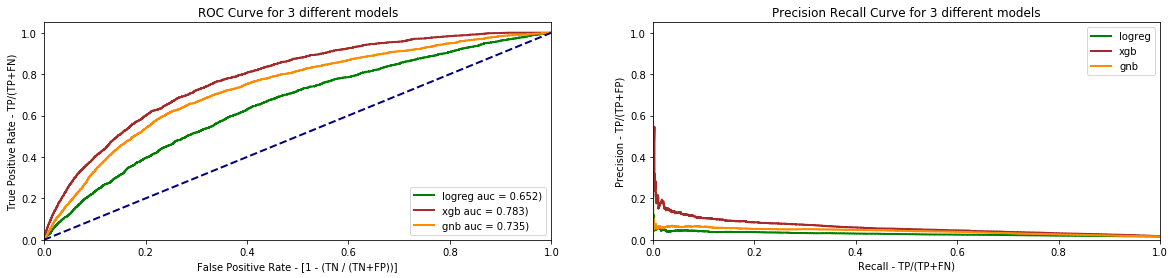

In [95]:
roc_fig = plt.figure(figsize = (20, 4))
lw = 2

ax1 = roc_fig.add_subplot(121)
plt.plot(fpr_logreg, tpr_logreg, color='green',
         lw=lw, label='logreg auc = %0.3f)' % auc_logreg)
plt.plot(fpr_xgb, tpr_xgb, color='brown',
         lw=lw, label='xgb auc = %0.3f)' % auc_xgb)
plt.plot(fpr_gnb, tpr_gnb, color='darkorange',
         lw=lw, label='gnb auc = %0.3f)' % auc_gnb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate - [1 - (TN / (TN+FP))]')
plt.ylabel('True Positive Rate - TP/(TP+FN)')
plt.title('ROC Curve for 3 different models')
plt.legend(loc="lower right");

ax2 = roc_fig.add_subplot(122)
plt.plot(recall_logreg, precision_logreg, color='green',
         lw=lw, label='logreg')
plt.plot(recall_xgb, precision_xgb, color='brown',
         lw=lw, label='xgb')
plt.plot(recall_gnb, precision_gnb, color='darkorange',
         lw=lw, label='gnb')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Precision - TP/(TP+FP)')
plt.xlabel('Recall - TP/(TP+FN)')
plt.title('Precision Recall Curve for 3 different models')
plt.legend(loc="top right");

In [96]:
roc_xgb['fnr_xgb'] = 1 - roc_xgb.tpr_xgb
roc_xgb['tnr_xgb'] = 1 - roc_xgb.fpr_xgb
np.round(roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, ], 3)

,xgb_threshold,tpr_xgb,fpr_xgb,tpr_minus_fpr,fnr_xgb,tnr_xgb
2967,0.426,0.765,0.34,0.425,0.235,0.66


In [97]:
#save these values for summary output
tpr_xgb = roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, 'tpr_xgb'].item() 
fpr_xgb = roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, 'fpr_xgb'].item() 
tnr_xgb = roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, 'tnr_xgb'].item() 
fnr_xgb = roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, 'fnr_xgb'].item() 

In [98]:
eval_df['xgb_best_threshold_preds'] = np.where(eval_df.xgb_pred_probs >= roc_xgb.loc[ roc_xgb.tpr_minus_fpr == max_diff, 'xgb_threshold'].item(), 1, 0)

In [99]:
xgb_best_threshold_df = pd.crosstab(eval_df.y, eval_df.xgb_best_threshold_preds).unstack().reset_index()
xgb_best_threshold_df.columns = ['xgb_best_threshold_pred', 'y', 'count']
xgb_best_threshold_df

def pred_type_map(row):
    if (row['y'] == 0):
        if (row['xgb_best_threshold_pred'] == 0):
            return 'TN'
        else:
            return 'FP'
    else:
        if (row['xgb_best_threshold_pred'] == 1):
            return 'TP'
        else:
            return 'FN'

xgb_best_threshold_df['pred_type'] = xgb_best_threshold_df.apply(pred_type_map, axis = 1)

In [100]:
xgb_best_threshold_df

,xgb_best_threshold_pred,y,count,pred_type
0,0,0,76911,TN
1,0,1,435,FN
2,1,0,39612,FP
3,1,1,1413,TP


In [101]:
precision_best_threshold = (xgb_best_threshold_df.loc[ xgb_best_threshold_df.pred_type == 'TP', 'count'] / xgb_best_threshold_df.loc[ xgb_best_threshold_df.pred_type.isin(['TP','FP']), 'count'].sum()).item()

#### Provide an estimate of performance using an appropriate sample, and show your work.

- across all thresholds for classification, the gradient boosted tree (xgb) is best at recognizing positive cases correctly while minimizing false positives, seen in its ROC curve lying markedly above that of the other 2 models
- the xgb model is also best in the precision-recall curve graph because it has universally higher precision across all values of recall compared to the other models

#### therefore, among the models built, xgb is the best model: its performance is as follows

In [102]:
Markdown("True Positive Rate: {:.2%}, False Positive Rate: {:.2%}, True Negative Rate: {:.2%}, False Negative Rate: {:.2%}, Precision: {:.2%}, AUC: {:0.3f}".format(tpr_xgb, fpr_xgb, tnr_xgb, fnr_xgb, precision_best_threshold, auc_xgb))

True Positive Rate: 76.46%, False Positive Rate: 34.00%, True Negative Rate: 66.00%, False Negative Rate: 23.54%, Precision: 3.44%, AUC: 0.783

- however, the xgb model's low precision is very concerning and is one thing that signals that this model is not close to production ready despite performing better than the other 2
- after reviewing the dataframe with counts of TP, FP, TN, FN, it is obvious that the model's precision is universally low because >90% of the model's predicted positive cases are actually negatives, making them False Positives -> therefore, the model is still not able to differentiate sufficiently well between positive and negative cases well among the negative cases, requiring significant improvement before moving forward

Some of the things that I would do given more time to improve the model are
1. dialogue with business stakeholders and analysts regarding trends in fraud cases that they have noticed to inform creating new derived variables and adding new variables
2. determine what other data is available that could be used to add new explanatory variables in the model
3. explore creating other derived explanatory variables, including interactions
4. try other models with different objective functions and parameterizations including support vector machines, neural network, nearest neighbors, etc. to see if their performance is better than the xgb model
5. examine the champion model's performance at different values of hyperparameters with a grid search. for the gradient boosted model, this would include learning rate, number of boosting rounds, weights for positive samples, sampling method, tree depth, lambda regularization parameter, boosting the model based on auc instead of mean average precision
6. discuss different weights/costs/benefit values with business stakeholders for true positives, false positives, true negatives and false negatives to inform selecting the optimal threshold, e.g. a false negative has cost -100 but false positive only -1 while true positive has benefit 100 and true negative benefit 10